In [40]:
import os
import pandas as pd
import requests, json

In [41]:
#Whole foods UPCS from econ_1923 GitHub
GE_WF_UPCSs = ["16000124790", "16000122543", "16000125063", "16000123991", "16000487727", "30000060834", "16000124950", "16000125933", "16000275157", "16000124998", "16000487949", "30000063224", "884912004710", "16000487932", "884912014269", "30000063545", "884912129659", "16000103719", "38000199240", "16000163461", "38000198717", "884912111715", "884912249265", "16000126855", "884912126115", "16000120259", "884912002372", "38000200458", "16000163614", "30000064306", "884912102102", "16000152335", "884912116505", "16000275638", "43000129715", "16000157811", "38000787041", "16000121836", "21908455563", "43000129517", "884912126016", "16000163669", "30000061534", "30034019082", "884912249272", "13562002474", "884912117625", "43000014271", "884912114600", "38000200663"]

In [42]:
whole_foods_shelf = GE_WF_UPCSs

In [43]:
%run APIkeys.py

# UPC Processing Funcitons

In [44]:
def checkUPC_V2(upc):
    app_id = os.environ['EDAMAM_API_id']
    key = os.environ['EDAMAM_API_key']
    baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
    endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = baseURL + upc + endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        answer['upc'] = upc
        return answer

In [45]:
def run_shelf(shelf, verbose = False, leftovers = False, source=""):
    
    # Shelf - a list of strings, each representing a UPC code
    # verbose - boolean telling the function whether to print found/unfound UPCs
    # leftovers - boolean telling the function whetehr to output the 
    
    found = []    #container for information on found UPCS
    unfound = []  #container for unfound UPCs
    
    # loop over UPCs in shelf
    for upc in shelf:
        info = checkUPC_V2(upc)
        
        if 'error' in info:
            unfound.append(upc) #add to the unfound container
            if verbose:
                print('UPC ',upc, ' does not exist in the API\'s data base')
        
        else:
            if verbose:
                print('UPC ',upc, ' exists in the API\'s data base')
            found.append(info)
    
    # turn the dictionary found into aDataframe
    if len(found)>0:
        df_found = pd.DataFrame(found)
    else:
        df_found = pd.DataFrame()
    
    # add a source column
    df_found["dataSource"] = pd.Series([source for i in range(len(df_found.index))])
    
    
    # return the values of found and unfound (optional)
    if leftovers:
        return df_found.head(),unfound
    else:
        return df_found.head()

In [89]:
# reading in Kaggle data from GitHub
df1 = pd.read_csv('/Users/natemcdowell/Desktop/edamamAPI_project/cereal_kaggle.csv', delimiter=',')
df1.dataframeName = 'cereal.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 77 rows and 16 columns


In [47]:
df1

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
74,Wheat Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3,110,25,1,1.0,1.00,51.592193


In [90]:
#cleaning. 
df1 = df1.loc[df1["type"] !='H'] # there were 3 instances of type = 'H' so I dropped to avoid confusion
df1 = df1.drop(columns = {'mfr','type','rating',"weight","shelf"}) # drop unnecessary
df1['source'] = 'kaggle'

In [49]:
df2 = run_shelf(whole_foods_shelf)

In [50]:
df2 = df2.rename(columns = {"label":"name",
                           "SUGAR":"sugars",
                           "FAT":"fat",
                           "FIBTG":"fiber",
                            "ENERC_KCAL":"calorie",
                            "PROCNT":"protein",
                            "K":"potass",
                            "NA":"sodium",
                            "CHOCDF":"carbo",
                            "servingSize_cup":"cups"
                           })
df2['source'] = 'edamam, whole foods'

In [51]:
df2 = df2[["name",
         "sugars",
         "fat",
         "fiber",
         "calorie",
          "protein",
          "potass",
          "sodium",
          "carbo",
          "cups",
           "source"
          ]]

In [52]:
df1.head()
df2= df2[["name","calorie","protein","fat","sodium","fiber","carbo","sugars","potass","cups", "source"]]
df1 = df1.drop(columns = {"vitamins"})

In [53]:
df2.head()

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
1,Cinnamon Toast Crunch Cereal,419.000000,3.230000,9.680000,581.00000,6.500000,80.650002,29.030001,177.000000,0.75,"edamam, whole foods"
2,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,7.407407,3.703704,629.62963,7.407407,81.481481,37.037037,185.185185,0.75,"edamam, whole foods"
4,Cheerios Cereal,357.000000,10.710000,7.140000,500.00000,10.700000,71.430000,3.570000,643.000000,1.00,"edamam, whole foods"


In [54]:
df1 = df1.rename(columns = {"calories":"calorie"})
df1

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,100% Bran,70,4,1,130,10.0,5.0,6,280,0.33,kaggle
1,100% Natural Bran,120,3,5,15,2.0,8.0,8,135,1.00,kaggle
2,All-Bran,70,4,1,260,9.0,7.0,5,320,0.33,kaggle
3,All-Bran with Extra Fiber,50,4,0,140,14.0,8.0,0,330,0.50,kaggle
4,Almond Delight,110,2,2,200,1.0,14.0,8,-1,0.75,kaggle
...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,110,2,1,250,0.0,21.0,3,60,0.75,kaggle
73,Trix,110,1,1,140,0.0,13.0,12,25,1.00,kaggle
74,Wheat Chex,100,3,1,230,3.0,17.0,3,115,0.67,kaggle
75,Wheaties,100,3,1,200,3.0,17.0,3,110,1.00,kaggle


In [55]:
frames = [df1,df2]

In [56]:
result = pd.concat(frames)

In [66]:
#merged dataframe
result

,name,calorie,protein,fat,sodium,fiber,carbo,sugars,potass,cups,source
0,100% Bran,70.000000,4.000000,1.000000,130.00000,10.000000,5.000000,6.000000,280.000000,0.33,kaggle
1,100% Natural Bran,120.000000,3.000000,5.000000,15.00000,2.000000,8.000000,8.000000,135.000000,1.00,kaggle
2,All-Bran,70.000000,4.000000,1.000000,260.00000,9.000000,7.000000,5.000000,320.000000,0.33,kaggle
3,All-Bran with Extra Fiber,50.000000,4.000000,0.000000,140.00000,14.000000,8.000000,0.000000,330.000000,0.50,kaggle
4,Almond Delight,110.000000,2.000000,2.000000,200.00000,1.000000,14.000000,8.000000,-1.000000,0.75,kaggle
...,...,...,...,...,...,...,...,...,...,...,...
0,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
1,Cinnamon Toast Crunch Cereal,419.000000,3.230000,9.680000,581.00000,6.500000,80.650002,29.030001,177.000000,0.75,"edamam, whole foods"
2,Honey Nut Cheerios,393.000000,7.140000,5.360000,571.00000,7.100000,78.570000,32.139999,411.000000,0.75,"edamam, whole foods"
3,"Lucky Charms Cereal Frosted Toasted Oat, With ...",407.407407,7.407407,3.703704,629.62963,7.407407,81.481481,37.037037,185.185185,0.75,"edamam, whole foods"


In [67]:
import seaborn as sns

<AxesSubplot:>

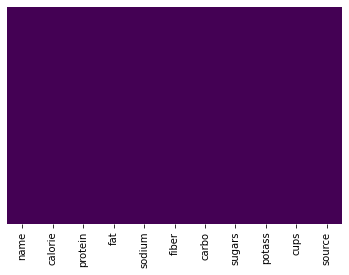

In [68]:
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Descriptive Statistics
Should normalize the data prior to creating visualizations

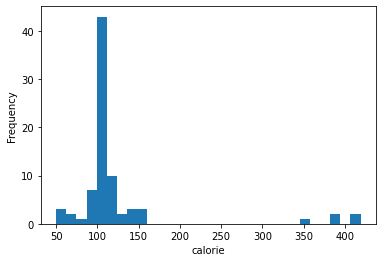

mean: 125.3089545241444
median: 110.0
min: 50.0
max: 419.0
stdev: 73.02128272297129
______________________________________________________________________



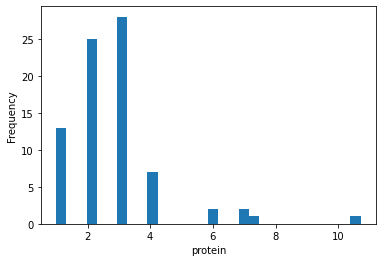

mean: 2.780093761994925
median: 3.0
min: 1.0
max: 10.710000038146973
stdev: 1.6462120346392324
______________________________________________________________________



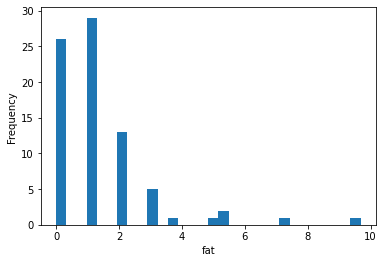

mean: 1.3448570144606822
median: 1.0
min: 0.0
max: 9.680000305175781
stdev: 1.6945464457503874
______________________________________________________________________



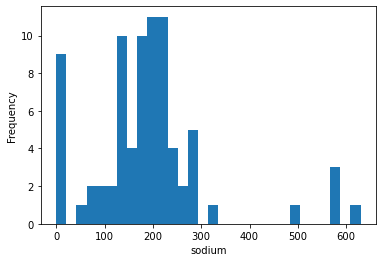

mean: 190.72948898265355
median: 180.0
min: 0.0
max: 629.6296296296297
stdev: 126.75234135643575
______________________________________________________________________



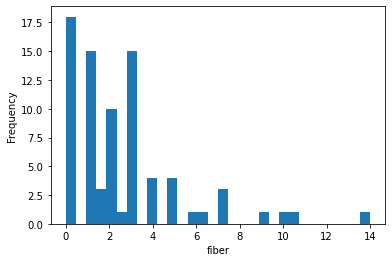

mean: 2.54186591172073
median: 2.0
min: 0.0
max: 14.0
stdev: 2.7315914750893255
______________________________________________________________________



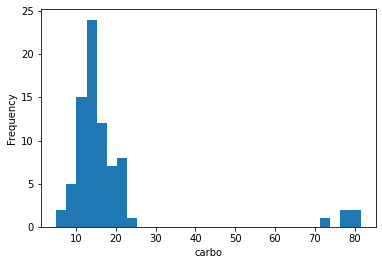

mean: 18.717740287369427
median: 15.0
min: 5.0
max: 81.48148148148148
stdev: 16.018994695585157
______________________________________________________________________



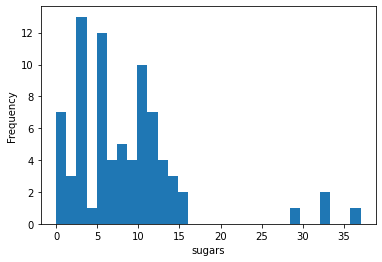

mean: 8.416671347293953
median: 7.0
min: 0.0
max: 37.03703703703704
stdev: 7.05091274733887
______________________________________________________________________



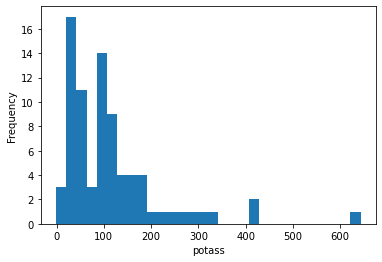

mean: 114.19221753398968
median: 90.0
min: -1.0
max: 643.0
stdev: 105.16412153434145
______________________________________________________________________



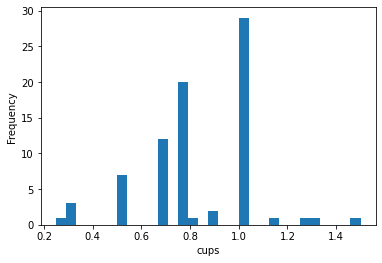

mean: 0.8170886075949368
median: 0.75
min: 0.25
max: 1.5
stdev: 0.22870960144171065
______________________________________________________________________



In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
subject = result.select_dtypes(include='number')
for x in subject:
    subject[x].plot.hist(bins = 30)
    plt.xlabel(x)
    plt.show()
    print("mean:",subject[x].mean())
    print("median:",subject[x].median())
    print("min:",subject[x].min())
    print("max:",subject[x].max())
    print("stdev:",subject[x].std())
    print("______________________________________________________________________")
    print("")

# Scatter Plots



In [91]:
#this function outputs the two factors with the highest positive correlation
target = result.select_dtypes(include='number')
target_pairs = []
for x in target: 
    for y in target:
        if 0.99 > target[x].corr(target[y]) > .9:  
            print(x,y, ":", target[x].corr(target[y]))
            target_pairs.append([x,y])
        

calorie carbo : 0.9543697664538403
carbo calorie : 0.9543697664538404


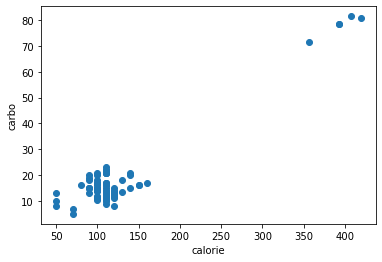

In [63]:
x = result['calorie']
y = result['carbo']
plt.scatter(x, y)
plt.xlabel("calorie")
plt.ylabel("carbo")
plt.show()

# K MEANS

In [65]:
def initialize_centroids(k, data):

    n_dims = data.shape[1]  #number of columns

    centroid_min = data.min()
    centroid_max = data.max()
    centroids = []
    
    for c in range(k):
        centroid = np.zeros(n_dims)
        for n in range(n_dims):
            centroid[n] = np.random.uniform(centroid_min[n], centroid_max[n])
        centroids.append(centroid)

    centroids = pd.DataFrame(centroids, columns = data.columns)

    return centroids

In [69]:
data = result[['calorie','carbo']]
centroids = initialize_centroids(3, data)
centroids

,calorie,carbo
0,244.563571,26.556736
1,244.382948,34.288493
2,299.619774,7.657867


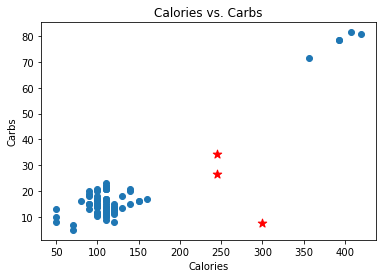

In [70]:
plt.scatter(result['calorie'], result['carbo'])
plt.title("Calories vs. Carbs")
plt.xlabel("Calories")
plt.ylabel("Carbs")

plt.scatter(centroids['calorie'], centroids['carbo'], s=80, c='red', marker = "*")

plt.show()

In [71]:
box = np.array(data.iloc[0])

In [72]:
print(f"1st product has {box[0]} grams of sodium and {box[1]} grams of carbs per serving.")
c1 =np.array(centroids.iloc[0])
print(f"Centroid 1 has  {round(c1[0],1)} grams of sodium and {round(c1[1],1)} grams of carbs per serving.")

1st product has 70.0 grams of sodium and 5.0 grams of carbs per serving.
Centroid 1 has  244.6 grams of sodium and 26.6 grams of carbs per serving.


In [73]:
def dist(a,b):
    '''
    Given two Numpy Arrays, calculates the root of the sum of squared errores.
    '''
    d = np.sqrt(np.sum((a-b)**2))

    return d 

In [74]:
for i in range(3):
    c = np.array(centroids.iloc[i])
    d = dist(box,c)
    print(f"The distance between the first product and centroid # {i+1} is {round(d,2)}")   

The distance between the first product and centroid # 1 is 175.89
The distance between the first product and centroid # 2 is 176.83
The distance between the first product and centroid # 3 is 229.64


In [75]:
def classify(box,centroids):
    k = centroids.shape[0]
    lowest = float('inf')
    cluster = 0
    for i in range(k):
        c = np.array(centroids.iloc[i])
        d = dist(box,c)
        if d < lowest:
            lowest = d
            cluster = i
    return cluster,lowest
    

In [76]:
cl,di = classify(box,centroids)

In [77]:
print(f"The closest centroid is # {cl+1} ")

The closest centroid is # 1 


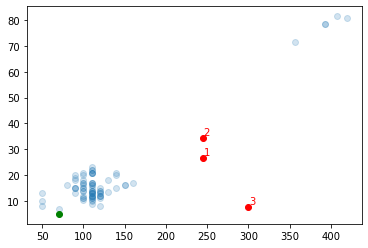

In [78]:
plt.scatter(data.iloc[1:,0], data.iloc[1:,1],  marker = 'o', alpha = 0.2)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', c = 'r')
plt.scatter(data.iloc[0,0], data.iloc[0,1],  marker = 'o', c = 'g')
for i in range(centroids.shape[0]):
    plt.text(centroids.iloc[i,0]+1, centroids.iloc[i,1]+1, s = centroids.index[i]+1, c = 'r')

In [79]:
def assign_centroid(data, centroids):
    '''
    Receives a dataframe of data and centroids and returns a list assigning each observation a centroid.
    data: a dataframe with all data that will be used.
    centroids: a dataframe with the centroids. For assignment the index will be used.
    '''

    n_observations = data.shape[0]
    centroid_assign = []
    centroid_dist = []
    k = centroids.shape[0]


    for observation in range(n_observations):
        
        # calculate closest centroid and error
        box = data.iloc[observation,:2]
        cl,di = classify(box,centroids)
                
        # Assign values to lists
        centroid_assign.append(cl)
        centroid_dist.append(di)

    return (centroid_assign,centroid_dist)

data['centroid'], data['dist'] = assign_centroid(data.iloc[:,:2] ,centroids)
data[['centroid', 'dist']].head()

<ipython-input-79-8ec0d80b7ce7>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['centroid'], data['dist'] = assign_centroid(data.iloc[:,:2] ,centroids)


,centroid,dist
0,0,175.889548
1,0,125.938221
2,0,175.655646
3,0,195.446503
4,0,135.148164


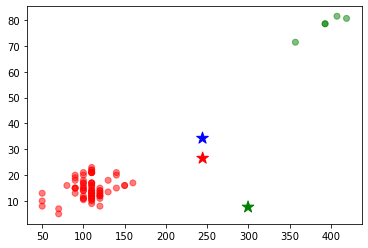

In [80]:
colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = '*', s=150, 
           c = centroids.index.map(lambda x: colors[x]))
plt.show()

In [81]:
print(f"The total error so far: {round(data['dist'].sum(),2)}")

The total error so far: 10800.15


In [82]:
data

,calorie,carbo,centroid,dist
0,70.000000,5.000000,0,175.889548
1,120.000000,8.000000,0,125.938221
2,70.000000,7.000000,0,175.655646
3,50.000000,8.000000,0,195.446503
4,110.000000,14.000000,0,135.148164
...,...,...,...,...
0,393.000000,78.570000,2,117.253560
1,419.000000,80.650002,2,139.926731
2,393.000000,78.570000,2,117.253560
3,407.407407,81.481481,2,130.644939


In [83]:
centroids = data.groupby('centroid').agg('mean').reset_index(drop = True).drop(['dist'], axis = 1)

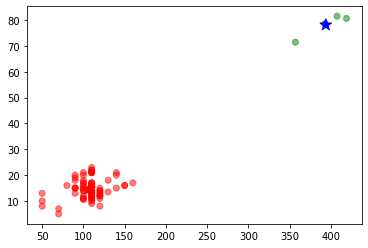

In [84]:
colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = '*', s=150, 
           c = centroids.index.map(lambda x: colors[x]))
plt.show()

In [85]:
data['centroid'], data['dist'] = assign_centroid(data.iloc[:,:2] ,centroids)
data[['centroid', 'dist']].head()

<ipython-input-85-5bc8253aa186>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['centroid'], data['dist'] = assign_centroid(data.iloc[:,:2] ,centroids)


,centroid,dist
0,0,38.407925
1,0,14.482276
2,0,37.952048
3,0,57.553792
4,0,2.923545


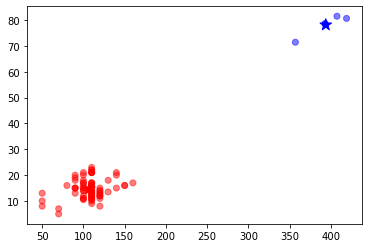

In [86]:
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = '*', s=150, 
           c = centroids.index.map(lambda x: colors[x]))
plt.show()

In [87]:
print(f"The total error so far: {round(data['dist'].sum(),2)}")

The total error so far: 1137.76
